# Makine Öğrenmesi Final — Wine Dataset (load_wine)

- Veri seti: `sklearn.datasets.load_wine()`
- Split: %70 Train / %10 Validation / %20 Test (Stratified)
- Ölçekleme: `StandardScaler` **Pipeline içinde** (data leakage yok)



In [1]:
# Eğer SHAP yüklü değilse aşağıdaki satırı açıp çalıştırın:
# !pip -q install shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.cluster import KMeans

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay,
    adjusted_rand_score, normalized_mutual_info_score,
    classification_report
)

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1) Veri Seti: Wine (`load_wine`)

In [2]:
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names
class_names = wine.target_names

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print("X shape:", X.shape)           # (178, 13)
print("Num classes:", len(np.unique(y)))
print("Class distribution:", dict(pd.Series(y).value_counts().sort_index()))
df.head()


X shape: (178, 13)
Num classes: 3
Class distribution: {0: np.int64(59), 1: np.int64(71), 2: np.int64(48)}


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


## 2) Train / Validation / Test Split (%70 / %10 / %20)
Önce %80 Train+Val, %20 Test; sonra Train+Val içinden %12.5 Val olacak şekilde bölüyoruz (0.8×0.125=0.10).

In [3]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.125, random_state=RANDOM_STATE, stratify=y_trainval
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (124, 13) Val: (18, 13) Test: (36, 13)


## 3) Yardımcı Fonksiyonlar (Metric + ROC + CM)
Macro metrikler kullanıyoruz. Multiclass ROC-AUC için **OvR** yaklaşımı uygulanır.

In [4]:
def evaluate_multiclass(model, X_eval, y_eval, average='macro'):
    """Modeli değerlendirir ve metrikleri sözlük olarak döner."""
    y_pred = model.predict(X_eval)
    metrics = {
        "accuracy": accuracy_score(y_eval, y_pred),
        "precision_macro": precision_score(y_eval, y_pred, average=average, zero_division=0),
        "recall_macro": recall_score(y_eval, y_pred, average=average, zero_division=0),
        "f1_macro": f1_score(y_eval, y_pred, average=average, zero_division=0),
    }
    # ROC-AUC (OvR) için olasılık lazım
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_eval)
        y_bin = label_binarize(y_eval, classes=np.unique(y))
        metrics["roc_auc_ovr_macro"] = roc_auc_score(
            y_bin, y_proba, multi_class="ovr", average="macro"
        )
    else:
        metrics["roc_auc_ovr_macro"] = np.nan
    return metrics

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap=None, colorbar=False)
    ax.set_title(title)
    plt.show()

def plot_multiclass_roc(model, X_eval, y_eval, title="ROC Curves (OvR)"):
    if not hasattr(model, "predict_proba"):
        print("ROC için predict_proba gerekli. Bu modelde yok.")
        return

    y_proba = model.predict_proba(X_eval)
    classes = np.unique(y_eval)
    y_bin = label_binarize(y_eval, classes=classes)

    fig, ax = plt.subplots(figsize=(7, 5))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
        ax.plot(fpr, tpr, label=f"{class_names[cls]} (AUC={auc(fpr,tpr):.3f})")

    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend()
    plt.show()


---
# 4) KNN — Baseline + k-F1 Grafiği + GridSearch
Pipeline: **StandardScaler + KNN**

KNN için özellikle ölçekleme çok önemlidir; bu yüzden scaler mutlaka pipeline içindedir (leakage yok).

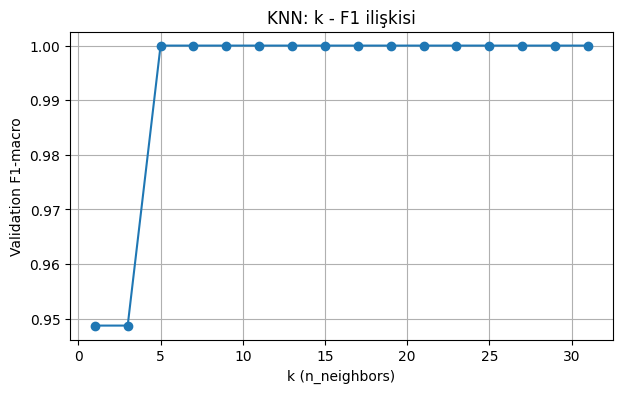

In [5]:
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# k-F1 grafiği (validation üstünde)
k_list = list(range(1, 32, 2))
f1_list = []

for k in k_list:
    tmp = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    tmp.fit(X_train, y_train)
    y_pred = tmp.predict(X_val)
    f1_list.append(f1_score(y_val, y_pred, average="macro"))

plt.figure(figsize=(7,4))
plt.plot(k_list, f1_list, marker="o")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Validation F1-macro")
plt.title("KNN: k - F1 ilişkisi")
plt.grid(True)
plt.show()


In [6]:
# GridSearch (train üzerinde CV)
knn_param_grid = {
    "knn__n_neighbors": list(range(1, 32, 2)),
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],  # Manhattan vs Euclidean
}

knn_gs = GridSearchCV(
    knn_pipe, knn_param_grid, scoring="f1_macro", cv=5, n_jobs=-1
)
knn_gs.fit(X_train, y_train)

print("Best KNN params:", knn_gs.best_params_)
print("Best CV F1:", knn_gs.best_score_)

knn_best = knn_gs.best_estimator_
knn_val_metrics = evaluate_multiclass(knn_best, X_val, y_val)
knn_val_metrics


Best KNN params: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}
Best CV F1: 0.9846164430684554


{'accuracy': 1.0,
 'precision_macro': 1.0,
 'recall_macro': 1.0,
 'f1_macro': 1.0,
 'roc_auc_ovr_macro': np.float64(1.0)}

---
# 5) SVM — Linear & RBF + GridSearch + ROC
SVM için `probability=True` ile ROC-AUC hesaplayabilmek adına olasılık çıktısı alıyoruz.

In [7]:
svm_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", probability=True, random_state=RANDOM_STATE))
])

svm_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))
])

svm_linear_grid = {
    "svm__C": [0.1, 1, 10, 100]
}

svm_rbf_grid = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": ["scale", 0.01, 0.1, 1]
}

svm_lin_gs = GridSearchCV(svm_linear, svm_linear_grid, scoring="f1_macro", cv=5, n_jobs=-1)
svm_rbf_gs = GridSearchCV(svm_rbf, svm_rbf_grid, scoring="f1_macro", cv=5, n_jobs=-1)

svm_lin_gs.fit(X_train, y_train)
svm_rbf_gs.fit(X_train, y_train)

print("Best SVM-Linear params:", svm_lin_gs.best_params_, "CV F1:", svm_lin_gs.best_score_)
print("Best SVM-RBF params:", svm_rbf_gs.best_params_, "CV F1:", svm_rbf_gs.best_score_)

svm_lin_best = svm_lin_gs.best_estimator_
svm_rbf_best = svm_rbf_gs.best_estimator_

svm_lin_val_metrics = evaluate_multiclass(svm_lin_best, X_val, y_val)
svm_rbf_val_metrics = evaluate_multiclass(svm_rbf_best, X_val, y_val)

svm_lin_val_metrics, svm_rbf_val_metrics


Best SVM-Linear params: {'svm__C': 1} CV F1: 0.9851393188854489
Best SVM-RBF params: {'svm__C': 100, 'svm__gamma': 0.01} CV F1: 0.9925696594427244


({'accuracy': 1.0,
  'precision_macro': 1.0,
  'recall_macro': 1.0,
  'f1_macro': 1.0,
  'roc_auc_ovr_macro': np.float64(1.0)},
 {'accuracy': 1.0,
  'precision_macro': 1.0,
  'recall_macro': 1.0,
  'f1_macro': 1.0,
  'roc_auc_ovr_macro': np.float64(1.0)})

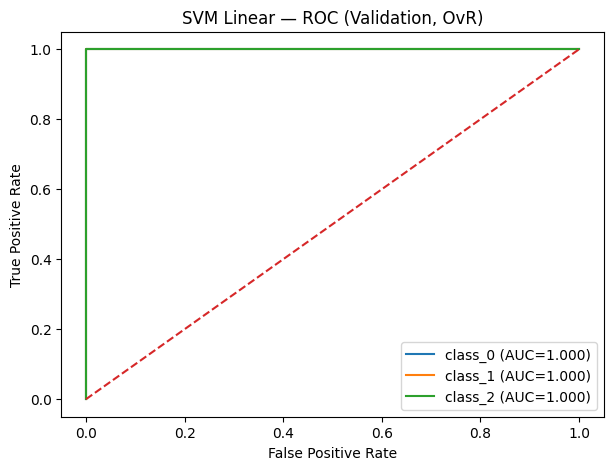

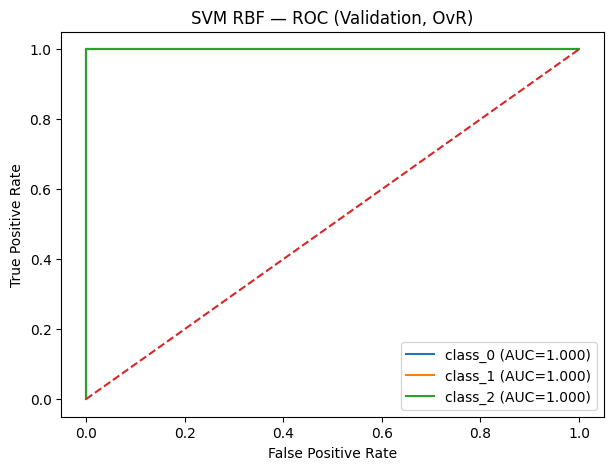

In [8]:
# ROC eğrileri (Validation)
plot_multiclass_roc(svm_lin_best, X_val, y_val, title="SVM Linear — ROC (Validation, OvR)")
plot_multiclass_roc(svm_rbf_best, X_val, y_val, title="SVM RBF — ROC (Validation, OvR)")


---
# 6) MLP — Baseline + RandomizedSearch + Loss Curve
MLP için en az 3 hiperparametreyi optimize ediyoruz (hidden_layer_sizes, alpha, learning_rate_init, activation).

Not: `early_stopping=True` ile overfitting riskini azaltıyoruz (validation split içsel).

In [9]:
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        max_iter=2000,
        random_state=RANDOM_STATE,
        early_stopping=True
    ))
])

mlp_param_dist = {
    "mlp__hidden_layer_sizes": [(32,), (64,), (64,32), (128,), (128,64)],
    "mlp__activation": ["relu", "tanh", "logistic"],
    "mlp__alpha": [1e-5, 1e-4, 1e-3, 1e-2],
    "mlp__learning_rate_init": [1e-4, 5e-4, 1e-3, 5e-3],
    "mlp__solver": ["adam"]
}

mlp_rs = RandomizedSearchCV(
    mlp_pipe,
    mlp_param_dist,
    n_iter=30,
    scoring="f1_macro",
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

mlp_rs.fit(X_train, y_train)

print("Best MLP params:", mlp_rs.best_params_)
print("Best CV F1:", mlp_rs.best_score_)

mlp_best = mlp_rs.best_estimator_
mlp_val_metrics = evaluate_multiclass(mlp_best, X_val, y_val)
mlp_val_metrics


Best MLP params: {'mlp__solver': 'adam', 'mlp__learning_rate_init': 0.005, 'mlp__hidden_layer_sizes': (128,), 'mlp__alpha': 1e-05, 'mlp__activation': 'relu'}
Best CV F1: 0.9284706865202221


{'accuracy': 1.0,
 'precision_macro': 1.0,
 'recall_macro': 1.0,
 'f1_macro': 1.0,
 'roc_auc_ovr_macro': np.float64(1.0)}

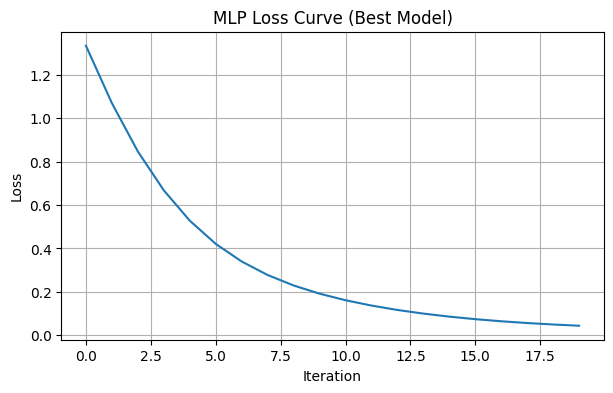

In [10]:
# Loss curve (best MLP)
best_mlp_model = mlp_best.named_steps["mlp"]
plt.figure(figsize=(7,4))
plt.plot(best_mlp_model.loss_curve_)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("MLP Loss Curve (Best Model)")
plt.grid(True)
plt.show()


---
# 7) Validation Sonuçlarının Karşılaştırılması (Tablo)
KNN / SVM-Linear / SVM-RBF / MLP validation metrikleri tek tabloda.

In [11]:
val_table = pd.DataFrame({
    "KNN": knn_val_metrics,
    "SVM_Linear": svm_lin_val_metrics,
    "SVM_RBF": svm_rbf_val_metrics,
    "MLP": mlp_val_metrics
}).T

val_table


,accuracy,precision_macro,recall_macro,f1_macro,roc_auc_ovr_macro
KNN,1.0,1.0,1.0,1.0,1.0
SVM_Linear,1.0,1.0,1.0,1.0,1.0
SVM_RBF,1.0,1.0,1.0,1.0,1.0
MLP,1.0,1.0,1.0,1.0,1.0


## 8) En İyi Model Seçimi
Öncelik: **F1-macro** (eşitlikte ROC-AUC).

In [12]:
# Best by F1_macro, tie-breaker roc_auc_ovr_macro
val_table_sorted = val_table.sort_values(
    by=["f1_macro", "roc_auc_ovr_macro"],
    ascending=False
)
val_table_sorted


,accuracy,precision_macro,recall_macro,f1_macro,roc_auc_ovr_macro
KNN,1.0,1.0,1.0,1.0,1.0
SVM_Linear,1.0,1.0,1.0,1.0,1.0
SVM_RBF,1.0,1.0,1.0,1.0,1.0
MLP,1.0,1.0,1.0,1.0,1.0


In [13]:
best_name = val_table_sorted.index[0]
print("Selected best model:", best_name)

model_map = {
    "KNN": knn_best,
    "SVM_Linear": svm_lin_best,
    "SVM_RBF": svm_rbf_best,
    "MLP": mlp_best
}

best_model = model_map[best_name]


Selected best model: KNN


---
# 9) Final Model: Train+Val ile Yeniden Eğit + Test Değerlendirme
Test seti **sadece en sonda** kullanılır. Bu aşamada en iyi hiperparametrelerle **Train+Val** birleştirilip yeniden fit edilir.

In [14]:
# Train+Val birleştir
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

final_model = best_model
final_model.fit(X_train_full, y_train_full)

test_metrics = evaluate_multiclass(final_model, X_test, y_test)
test_metrics


{'accuracy': 1.0,
 'precision_macro': 1.0,
 'recall_macro': 1.0,
 'f1_macro': 1.0,
 'roc_auc_ovr_macro': np.float64(1.0)}

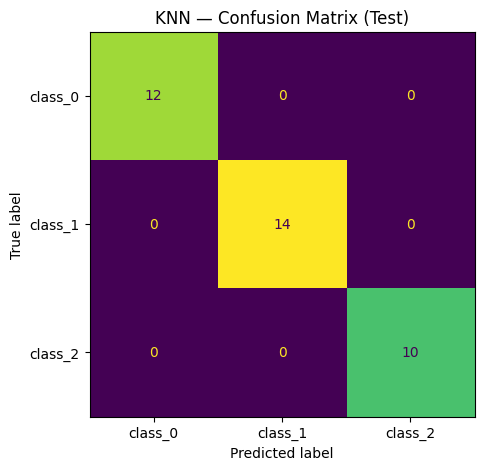

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       1.00      1.00      1.00        14
     class_2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [15]:
# Confusion Matrix + Classification Report
y_test_pred = final_model.predict(X_test)
plot_confusion(y_test, y_test_pred, title=f"{best_name} — Confusion Matrix (Test)")

print(classification_report(y_test, y_test_pred, target_names=class_names))


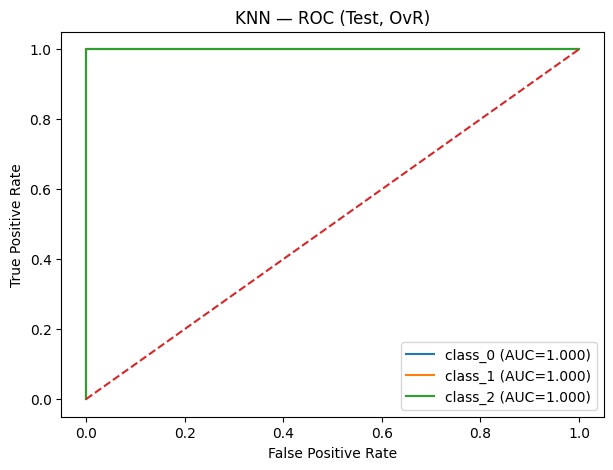

In [16]:
# ROC Curves (Test)
plot_multiclass_roc(final_model, X_test, y_test, title=f"{best_name} — ROC (Test, OvR)")


## 10) Threshold Senaryoları (Örnek)
Multiclass'ta threshold kullanımı için pratik bir yöntem: **'reject option'**.
- Senaryo A: daha **yüksek güven** (threshold ↑) → daha az yanlış pozitif, ama daha çok 'Unknown'
- Senaryo B: daha **çok kapsama** (threshold ↓) → daha az 'Unknown', ama daha çok hata

Aşağıda en yüksek olasılığı `t` altında kalan örnekleri 'Unknown' olarak işaretliyoruz ve sonuçları raporluyoruz.

In [17]:
def predict_with_reject(model, X_eval, threshold=0.7):
    proba = model.predict_proba(X_eval)
    pred = proba.argmax(axis=1)
    maxp = proba.max(axis=1)
    pred_reject = pred.copy()
    pred_reject[maxp < threshold] = -1  # Unknown
    return pred_reject, maxp

def report_reject(y_true, y_pred_reject):
    # Unknown'ları ayrı sayalım
    unknown_rate = (y_pred_reject == -1).mean()
    # Unknown hariç metrik
    mask = y_pred_reject != -1
    if mask.sum() == 0:
        return {"known_rate": 0.0, "unknown_rate": unknown_rate}
    return {
        "known_rate": mask.mean(),
        "unknown_rate": unknown_rate,
        "accuracy_known": accuracy_score(y_true[mask], y_pred_reject[mask]),
        "f1_macro_known": f1_score(y_true[mask], y_pred_reject[mask], average="macro", zero_division=0)
    }

for t in [0.8, 0.6]:
    pred_r, maxp = predict_with_reject(final_model, X_test, threshold=t)
    rep = report_reject(y_test, pred_r)
    print(f"Threshold={t} =>", rep)


Threshold=0.8 => {'known_rate': np.float64(0.8055555555555556), 'unknown_rate': np.float64(0.19444444444444445), 'accuracy_known': 1.0, 'f1_macro_known': 1.0}
Threshold=0.6 => {'known_rate': np.float64(0.9722222222222222), 'unknown_rate': np.float64(0.027777777777777776), 'accuracy_known': 1.0, 'f1_macro_known': 1.0}


---
# 11) KMeans — Elbow + Silhouette + ARI/NMI + Görselleştirme + Küme Profili
KMeans için ölçekleme önemlidir, bu nedenle StandardScaler uygulanır.

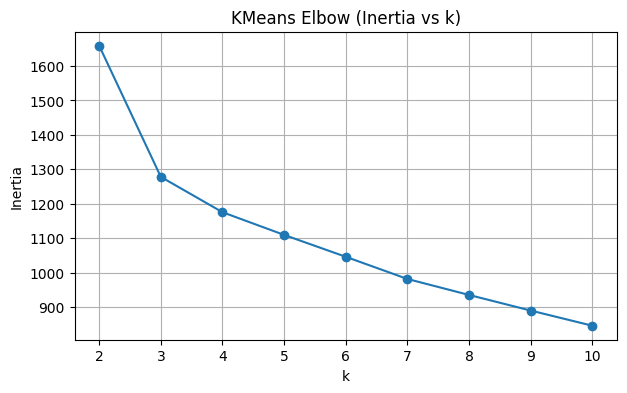

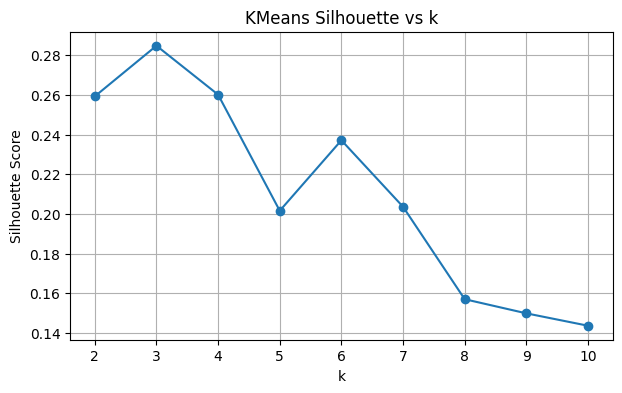

Chosen k (by max silhouette): 3


In [18]:
# Ölçekleme (KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ks = range(2, 11)
inertias = []
sil_scores = []

from sklearn.metrics import silhouette_score

for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Elbow plot
plt.figure(figsize=(7,4))
plt.plot(list(ks), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("KMeans Elbow (Inertia vs k)")
plt.grid(True)
plt.show()

# Silhouette plot
plt.figure(figsize=(7,4))
plt.plot(list(ks), sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("KMeans Silhouette vs k")
plt.grid(True)
plt.show()

best_k = list(ks)[int(np.argmax(sil_scores))]
print("Chosen k (by max silhouette):", best_k)


In [19]:
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

ari = adjusted_rand_score(y, clusters)
nmi = normalized_mutual_info_score(y, clusters)
print("ARI:", ari)
print("NMI:", nmi)


ARI: 0.8974949815093207
NMI: 0.8758935341223069


### 11.1) 2 Özellik ile Scatter (Cluster vs Gerçek Sınıf)
Boyut indirgeme kullanmadan 2 özellik seçiyoruz (örnek: `alcohol`, `color_intensity`).

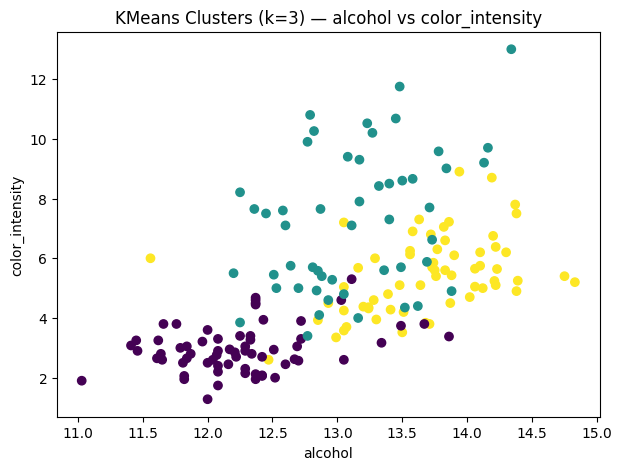

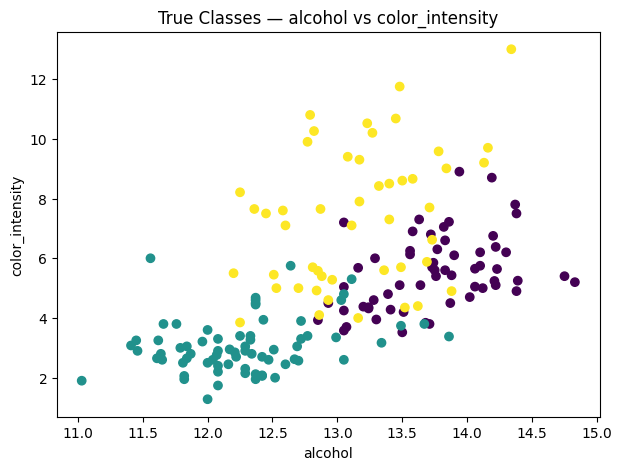

In [20]:
f1, f2 = "alcohol", "color_intensity"
i1, i2 = feature_names.index(f1), feature_names.index(f2)

plt.figure(figsize=(7,5))
plt.scatter(X[:, i1], X[:, i2], c=clusters)
plt.xlabel(f1)
plt.ylabel(f2)
plt.title(f"KMeans Clusters (k={best_k}) — {f1} vs {f2}")
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(X[:, i1], X[:, i2], c=y)
plt.xlabel(f1)
plt.ylabel(f2)
plt.title(f"True Classes — {f1} vs {f2}")
plt.show()


### 11.2) Küme Profili (En az 5 özellik)
Kümelerin ortalama özellik değerlerini karşılaştırıyoruz.

In [21]:
profile_features = ["alcohol", "malic_acid", "ash", "color_intensity", "proline"]
idxs = [feature_names.index(f) for f in profile_features]

profile_df = pd.DataFrame(X[:, idxs], columns=profile_features)
profile_df["cluster"] = clusters

cluster_profile = profile_df.groupby("cluster").mean().round(3)
cluster_profile


,alcohol,malic_acid,ash,color_intensity,proline
cluster,,,,,
0,12.251,1.897,2.231,2.973,510.169
1,13.134,3.307,2.418,7.235,619.059
2,13.677,1.998,2.466,5.454,1100.226


---
# 12) SHAP — En İyi Modelin Açıklanabilirliği
Bu bölümde **en iyi seçilen sınıflandırma modeli** için SHAP değerleri hesaplanır.

- Background örnek: 100
- Açıklanan örnek: 30

**Not:** Multiclass'ta SHAP, her sınıf için ayrı shap değerleri döndürebilir.

In [22]:
import shap

# SHAP için daha küçük bir örnekleme (hız için)
X_bg = shap.sample(X_train_full, 100, random_state=RANDOM_STATE)
X_explain = shap.sample(X_test, 30, random_state=RANDOM_STATE)

# Pipeline modelini doğrudan kullanarak predict_proba fonksiyonunu SHAP'a veriyoruz
explainer = shap.KernelExplainer(final_model.predict_proba, X_bg)

# Multiclass SHAP: genelde [n_classes] listesi dönebilir
shap_values = explainer.shap_values(X_explain, nsamples=200)

print(type(shap_values), "len:", len(shap_values) if isinstance(shap_values, list) else "n/a")


<class 'numpy.ndarray'> len: n/a


### 12.1) SHAP Summary Plot (örn. Class 0)
İsterseniz diğer sınıflar için de aynı grafikleri üretebilirsiniz.

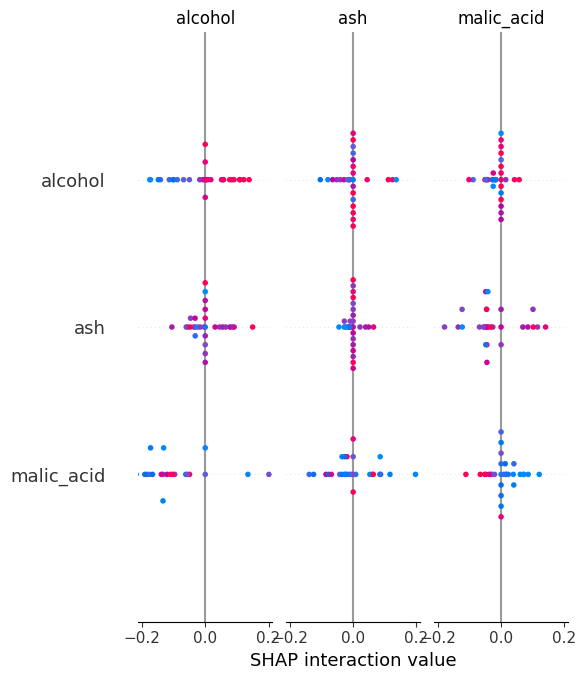

In [23]:
target_class = 0  # örnek: class 0
shap.summary_plot(
    shap_values[target_class] if isinstance(shap_values, list) else shap_values,
    X_explain,
    feature_names=feature_names,
    show=True
)


### 12.2) SHAP Bar Plot (Feature Importance)

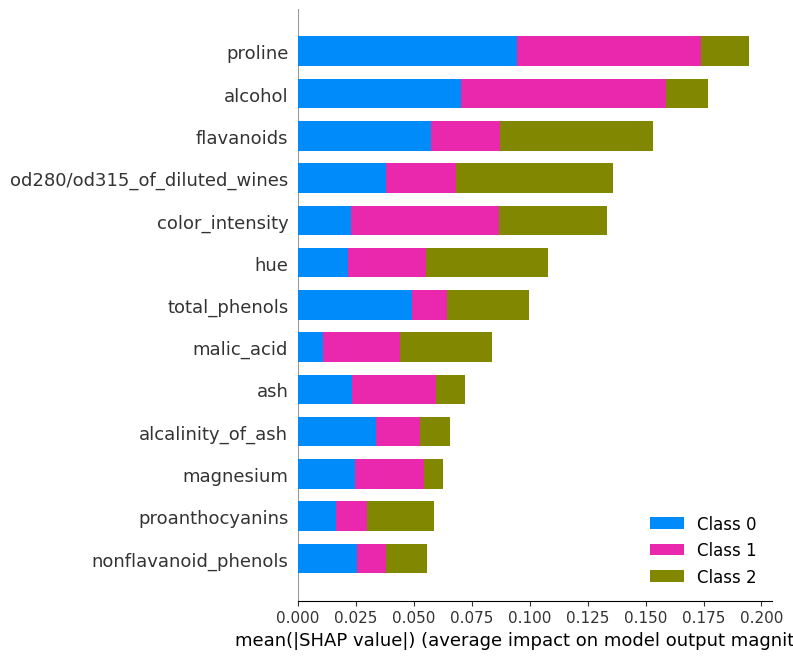

In [24]:
shap.summary_plot(
    shap_values[target_class] if isinstance(shap_values, list) else shap_values,
    X_explain,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)


---
## 13) Sonuç
- Modeller validation setinde karşılaştırıldı.
- En iyi model seçilip train+val ile yeniden eğitildi ve testte raporlandı.
- KMeans için Elbow+Silhouette ile k seçildi; ARI/NMI hesaplandı.
- SHAP ile seçilen modelin karar mantığı görselleştirildi.
